# Train the CNN classifier

Training of the **convolutional neural network classifier** for producing results with various **degrees of dataset imbalance**. The trained model is further saved to reproduce the results for testing.

## Import useful packages

In [ ]:
# Generic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

In [ ]:
# Sci-kit learn for machine learning tasks
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, make_scorer

In [ ]:
# TensorFlow and Keras for neural networks
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras import layers
from keras.layers.wrappers import Bidirectional
from keras.regularizers import l2
from keras import metrics
from tensorflow.keras.optimizers import Adam

In [ ]:
# NLTK for natural language processing
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# Custom helper-functions script (supplied to Colab manually)
import utils as uu

## Define the neural architecture

Best hyperparams:  {'batch_size': 30.0, 'dropout_rate': 0.3312500326531685, 'embedding_dim': 184.0, 'epochs': 99.0, 'kernel_size': 11.0, 'l2_val': 2.86715299646219e-05, 'learning_rate': 1.553281918810298e-05, 'n_filters': 44.0}

In [ ]:
# Set parameters tuned beforehand via Bayesian optimization
params = {'batch_size':     30,
          'dropout_rate':   0.3312500326531685,
          'embedding_dim':  184,
          'epochs':         99,
          'kernel_size':    11,
          'l2_val':         2.86715299646219e-05,
          'learning_rate':  1.553281918810298e-05,
          'max_words':      5000,
          'max_len':        55,
          'n_filters':      44,
          }

In [ ]:
# Define the neural model
def create_model(params, word_index):
    
    # Define optimizer
    opt = Adam(learning_rate=params['learning_rate'], 
               beta_1 = 0.9,
               beta_2 = 0.99,
               epsilon = 1e-07,
               amsgrad = False)

    # Define sequential neural arhitecture
    model = Sequential()
    model.add(layers.Embedding(params['max_words'], params['embedding_dim'], input_length=params['max_len']))
    model.add(layers.Dropout(params['dropout_rate']))
    model.add(layers.Conv1D(filters=params['n_filters'], kernel_size=params['kernel_size'], kernel_initializer='glorot_uniform', padding='same', activation='relu', kernel_regularizer=l2(params['l2_val']), bias_regularizer=l2(params['l2_val'])))
    model.add(layers.MaxPooling1D())
    model.add(layers.Flatten())
    model.add(layers.Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid', kernel_regularizer=l2(params['l2_val']), bias_regularizer=l2(params['l2_val'])))

    # Build model
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[metrics.AUC(name='auc_pr', curve="PR")])
    #model.compile(loss=[uu.focal_loss], optimizer=opt, metrics=[metrics.AUC(name='auc_pr', curve="PR")])
    model.summary()

    return model

## Load the datasets

In [ ]:
# Set file names
train_set_file  = "train_set_imb_0.csv"
test_set_file   = "test_set_imb_0.csv"
model_file      = "model_cnn_imb_0.h5"

In [ ]:
# Read train and test sets as dataframes
train_set = pd.read_csv(train_set_file)
test_set = pd.read_csv(test_set_file)

In [ ]:
# Preprocess texts
train_set['text'] = train_set['text'].apply(str)
train_set['text'] = train_set['text'].apply(uu.preprocess_text)
test_set['text'] = test_set['text'].apply(str)
test_set['text'] = test_set['text'].apply(uu.preprocess_text)

In [ ]:
# Decouple texts and labels (deep copy to not modfy the original datasets accidentally)
texts_train = copy.deepcopy(train_set['text'])
labels_train = copy.deepcopy(train_set['is_about_cc'])
texts_test = copy.deepcopy(test_set['text'])
labels_test = copy.deepcopy(test_set['is_about_cc'])

In [ ]:
# Show the test obtained set fraction (should be 15%)
share_test = len(labels_test)/(len(labels_train)+len(labels_test))
print(share_test)

0.149886976178056


## Create features and fit the model

In [ ]:
# Tokenize texts and get features
tokenizer = Tokenizer(num_words=params['max_words'])
tokenizer.fit_on_texts(texts_train)
sequences_train = tokenizer.texts_to_sequences(texts_train)
features_train = sequence.pad_sequences(sequences_train, maxlen=params['max_len'], padding='post', truncating='post')
sequences_test = tokenizer.texts_to_sequences(texts_test)
features_test = sequence.pad_sequences(sequences_test, maxlen=params['max_len'], padding='post', truncating='post')
word_index = tokenizer.word_index

In [ ]:
# Create the model
model = create_model(params, word_index=tokenizer.word_index)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 55, 184)           920000    
                                                                 
 dropout_9 (Dropout)         (None, 55, 184)           0         
                                                                 
 conv1d_9 (Conv1D)           (None, 55, 44)            89100     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 27, 44)           0         
 1D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 1188)              0         
                                                                 
 dense_8 (Dense)             (None, 1)                 1189      
                                                      

In [ ]:
# Compute class weights for compensation the imbalance in classes
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(labels_train), y = labels_train)
class_weights = dict(zip(np.unique(labels_train), class_weights))
print(class_weights)

{0: 0.540579389650597, 1: 6.660762942779291}


In [ ]:
# Fit the model
history = model.fit(features_train, labels_train, 
                    epochs=params['epochs'], 
                    verbose=True, 
                    batch_size=params['batch_size'], 
                    class_weight=class_weights) 


In [ ]:
# Save the model (needs to be downloaded manyally from Colab)
model.save(model_file)

## Test the model for performance

In [ ]:
# Compute PR AUC score (area under the precision-recall curve)
prediction_scores = model.predict(features_test).ravel()
precs, recs = uu.compute_pr(labels_test, prediction_scores)
pr_auc = auc(recs, precs)
pr_auc

0.6009923549741824

In [ ]:
# Compute F1 score
predicted_labels = (model.predict(features_test) > 0.5).astype(int)
acc, prec, rec, f1 = uu.compute_perf_metrics(labels_test, predicted_labels)
print("f1 = ", f1)

f1 =  0.5365853658536586


[[772  26]
 [ 31  33]]


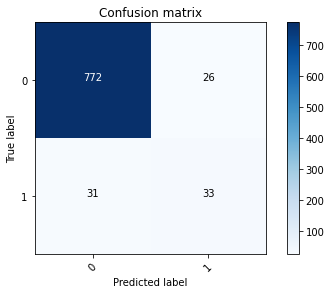

In [ ]:
# Compute confusion matrix
confusion_mat = confusion_matrix(labels_test, predicted_labels)
print(confusion_mat)
uu.plot_confusion_matrix(confusion_mat, classes=[0, 1], title='Confusion matrix')

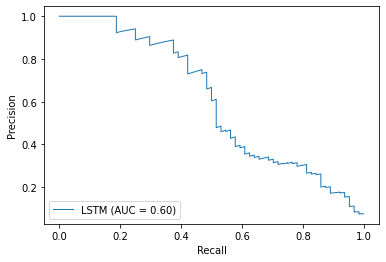

In [ ]:
# Plot precision-recall curve
plt.plot(recs, precs, linewidth=1, label=' '.join(['CNN', '(AUC = %0.2f)' % pr_auc]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")